In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.sparse import bmat, coo_matrix, diags, eye
from scipy.sparse.linalg import spsolve
from itertools import product

In [72]:
# Define parameters
Ds, Dc = 1, 1
kf, gam = -1, 1
lam = 0
N = 100
L = 5

z = np.linspace(0, L, num=N+1)
x = np.linspace(0, L, num=N+1)
h = x[1] - x[0]

In [73]:
# Set up matrix and vector

submatrices = [[None]*N for _ in range(N)]
rhs = [None]*N

## Construct the first block row
submatrices[0][0] = -eye(N, format='coo')
submatrices[0][1] = diags(np.ones(N-1), offsets=-1, shape=(N, N-1), format='coo')

## Construct the rest of the block matrix
for i in range(1, N):
    M = N - 1 - i
    diagonal = np.ones(N-i)
    diagonal[-1] = 0
    ### Construct the block subdiagonal
    submatrices[i][i-1] = (Ds/h**2 - kf/(2*h*gam)*(z[i] - lam))*diags(
        diagonal, offsets=1, shape=(N-i, N-i+1), format='coo')
    ### Construct the block diagonal
    part1 = diags(diagonal, offsets=0, shape=(N-i, N-i))
    if i < N - 1:
        part2 = coo_matrix(([1, -1], ([N-i-1, N-i-1], [N-i-2, N-i-1])), shape=(N-i, N-i))
    elif i == N - 1:
        part2 = coo_matrix(([-1], ([0], [0])), shape=(1,1))
    part3 = diags([diagonal[1:], diagonal[:-1]], offsets=[-1, 1], 
                  shape=(N-i, N-i), format='coo')
    submatrices[i][i] = -2*(Dc+Ds)/h**2*part1 + part2 + Dc/h**2*part3
    ### Construct the block superdiagonal
    if i < N - 1:
        submatrices[i][i+1] = (Ds/h**2 + kf/(2*h*gam)*(z[i] - lam))*diags(
            diagonal[1:], offsets=-1, shape=(N-i, N-i-1), format='coo')

## Construct a single matrix from the array of submatrices
A = bmat(submatrices, format='csr')
# print(A.toarray()) #Diagonal is correct, the superdiagonal was wrong
## Construct the rhs vector
rhs = np.zeros(N)
temp = -np.ones(N)
temp[-1] = 0
for i in range(1, N):
    rhs = np.append(rhs, temp[i:])
# print(rhs) #This is correct
## Solve the system
sol = spsolve(A, rhs)

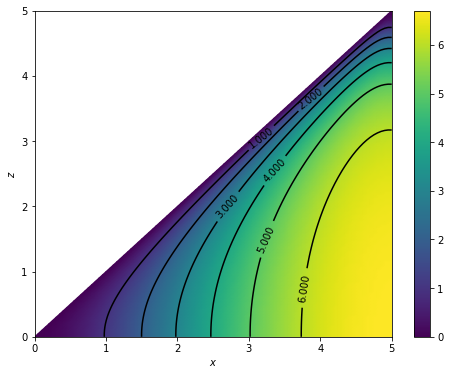

In [74]:
xtri = []
for i in range(N+1):
    xtri.append(x[i:])
xtri = np.hstack(xtri)
ztri = np.repeat(z, np.arange(1, N+2)[::-1])
npoints = xtri.shape[0]

trirows = []
for i in range(N+1, 1, -1):
    ti = i*(i+1)/2
    offset = npoints - ti
    for j in range(0, i-1):
        trirows.append(np.array([offset + j, offset + j + 1, offset + j + i]))
    if i > 2:
        for j in range(1, i-1):
            trirows.append(np.array([offset + j, offset + j + i, offset + j + i - 1]))
tri = np.vstack(trirows)

obj = []
tn = N*(N+1)/2
for i in range(N, 0, -1):
    obj.append(tn - i*(i+1)/2)
plot_sol = np.insert(sol, obj=np.array(obj), values=0)
plot_sol = np.append(plot_sol, 0)

plt.rcParams['figure.figsize'] = (8, 6)
triangulation = Triangulation(xtri, ztri, tri)
# plt.triplot(triangulation, 'k-', linewidth=0.1)
cs = plt.tricontour(triangulation, plot_sol, colors='k')
plt.clabel(cs)
plt.tripcolor(triangulation, plot_sol, shading='gouraud')
plt.xlabel('$x$')
plt.ylabel('$z$')
plt.colorbar()
plt.savefig('binding-times.png', dpi=300)
plt.show()

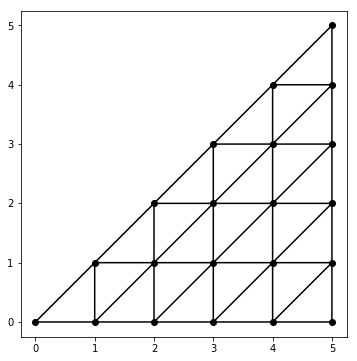

In [27]:
# Generate a sample mesh
Nsamp = 5
xsamp, zsamp = np.linspace(0, L, num=Nsamp+1), np.linspace(0, L, num=Nsamp+1)

xtrisamp = []
for i in range(Nsamp+1):
    xtrisamp.append(xsamp[i:])
xtrisamp = np.hstack(xtrisamp)
ztrisamp = np.repeat(zsamp, np.arange(1, Nsamp+2)[::-1])
npointssamp = xtrisamp.shape[0]

trirowssamp = []
for i in range(Nsamp+1, 1, -1):
    ti = i*(i+1)/2
    offset = npointssamp - ti
    for j in range(0, i-1):
        trirowssamp.append(np.array([offset + j, offset + j + 1, offset + j + i]))
    if i > 2:
        for j in range(1, i-1):
            trirowssamp.append(np.array([offset + j, offset + j + i, offset + j + i - 1]))
trisamp = np.vstack(trirowssamp)

fig, ax = plt.subplots()
ax.triplot(xtrisamp, ztrisamp, trisamp, 'k-o')
ax.set_aspect('equal')
plt.savefig('sample-mesh.png', dpi=300)
plt.show()

In [59]:
np.linalg.cond(A.toarray())

318348.65600635012